In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import scipy.io # Used to load the OCTAVE *.mat files
from random import sample #Used for random initialization
import scipy.misc #Used to display  images in a specific color map
import matplotlib.cm as cm # Used to display images in a specific colormaop
from scipy import linalg #Used for the "SVD" function
import imageio

# 1: Implementing K-means

1.1 finding closest centroids 

In [2]:
# Read in data.mat 
datafile = 'D:\corner_stone\ocr\data.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']

#X is 300 points, each has two coordinates
#IE the shape is (300,2)


In [3]:
#Choose the number of centroids.. k = 3
K = 3
#Choose the initial centroids matching ex7.m asssignment script
initial_centroids = np.array([[3,3],[6,2],[8,5]])

In [4]:
#Visualizing the data
def plotData(myX,mycentroids,myidxs = None):
    """
    Fucntion to plot the data and color it accordingly.
    myidxs should be the latest iteraction index vector
    mycentroids should be a vector of centroids, one per iteration
    """
    
    colors = ['b','g','gold','darkorange','salmon','olivedrab']
    
    assert myX[0].shape == mycentroids[0][0].shape
    assert mycentroids[-1].shape[0] <= len(colors)

    #If idxs is supplied, divide up X into colors
    if myidxs is not None:
        assert myidxs.shape[0] == myX.shape[0]
        subX = []
        for x in range(mycentroids[0].shape[0]):
            subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    else:
        subX = [myX]
        
    fig = plt.figure(figsize=(7,5))
    for x in range(len(subX)):
        newX = subX[x]
        plt.plot(newX[:,0],newX[:,1],'o',color=colors[x],
                 alpha=0.75, label='Data Points: Cluster %d'%x)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.grid(True)

    #Drawing a history of centroid movement
    tempx, tempy = [], []
    for mycentroid in mycentroids:
        tempx.append(mycentroid[:,0])
        tempy.append(mycentroid[:,1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'rx--', markersize=8)

    leg = plt.legend(loc=4, framealpha=0.5)

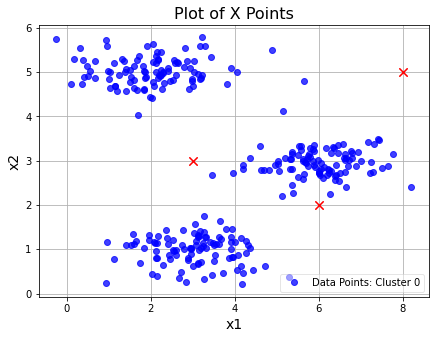

In [5]:
plotData(X,[initial_centroids])


In [6]:


def distSquared(point1, point2):
    assert point1.shape == point2.shape
    return np.sum(np.square(point2-point1))



In [7]:
def findClosestCentroids(myX, mycentroids):
    """
    Function takes in the (m,n) X matrix
    (where m is the # of points, n is # of features per point)
    and the (K,n) centroid seed matrix
    (where K is the # of centroids (clusters)
    and returns a (m,1) vector of cluster indices 
    per point in X (0 through K-1)
    """
    idxs = np.zeros((myX.shape[0],1))
    
    #Loop through each data point in X
    for x in range(idxs.shape[0]):
        mypoint = myX[x]
        #Compare this point to each centroid,
        #Keep track of shortest distance and index of shortest distance
        mindist, idx = 9999999, 0
        for i in range(mycentroids.shape[0]):
            mycentroid = mycentroids[i]
            distsquared = distSquared(mycentroid,mypoint)
            if distsquared < mindist:
                mindist = distsquared
                idx = i
        #With the best index found, modify the result idx vector
        idxs[x] = idx
        
    return idxs

In [8]:
idxs = findClosestCentroids(X,initial_centroids)

#you should see the output [1 3 2] corresponding to the 
#centroid assignments for the first 3 examples.
#Note my indices start at 0, so I should see [0, 2, 1]
print(idxs[:3].flatten())

[0. 2. 1.]


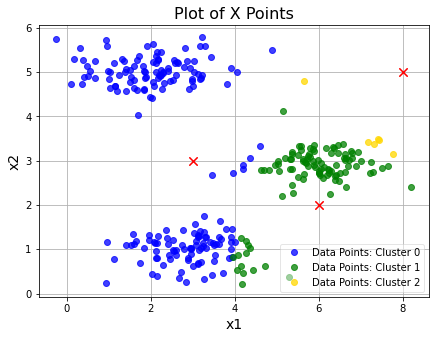

In [9]:


plotData(X,[initial_centroids],idxs)



1.2: Computing centroid means

In [10]:
def computeCentroids(myX, myidxs):
    """
    Function takes in the X matrix and the index vector
    and computes a new centroid matrix.
    """
    subX = []
    for x in range(len(np.unique(myidxs))):
        subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    return np.array([np.mean(thisX,axis=0) for thisX in subX])


2: K-means on example dataset

In [11]:
def runKMeans(myX, initial_centroids, K, n_iter):
    """
    Function that actually does the iterations
    """
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = findClosestCentroids(myX,current_centroids)
        current_centroids = computeCentroids(myX,idxs)
        
    return idxs, centroid_history

In [12]:
idxs, centroid_history = runKMeans(X,initial_centroids,K=3,n_iter=10)

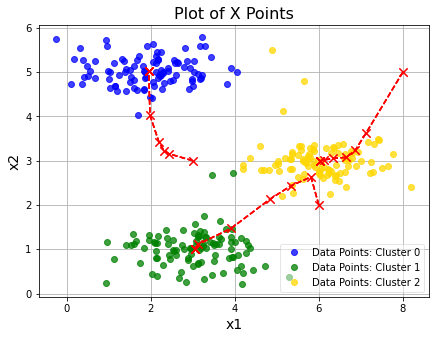

In [13]:
plotData(X,centroid_history,idxs)


3: Random initialization

In [14]:
def chooseKRandomCentroids(myX, K):
    rand_indices = sample(range(0,myX.shape[0]),K)
    return np.array([myX[i] for i in rand_indices])

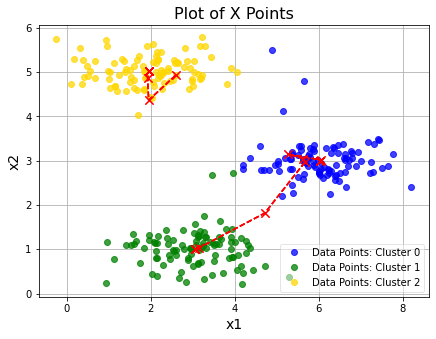

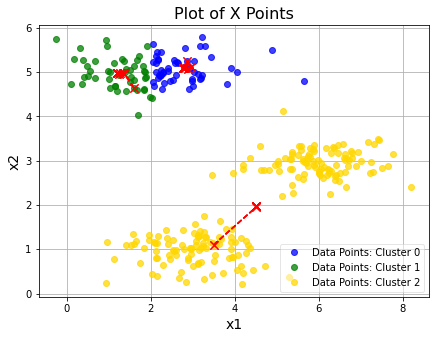

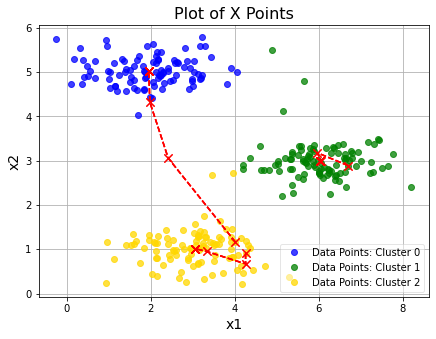

In [15]:
#Let's choose random initial centroids and see the resulting 
#centroid progression plot.. perhaps three times in a row
for x in range(3):
    idxs, centroid_history = runKMeans(X,chooseKRandomCentroids(X,K=3), K=3,n_iter=10)
    plotData(X,centroid_history,idxs)

4: Image compression with K-means

4.1: K-means on pixels

A shape is  (346, 346, 3)


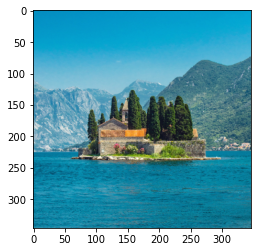

In [16]:

datafile = 'D:/corner_stone/ocr/image.png'

# This creates a three-dimensional matrix A whose first two indices 
# identify a pixel position and whose last index represents red, green, or blue.
A = imageio.imread(datafile)

print("A shape is ",A.shape)
dummy = plt.imshow(A)


In [17]:
# Divide every entry in A by 255 so all values are in the range of 0 to 1
A = A / 255.

# Unroll the image to shape (16384,3) (16384 is 128*128)
A = A.reshape(-1, 3)

# Run k-means on this data, forming 16 clusters, with random initialization
myK = 16
idxs, centroid_history = runKMeans(A,chooseKRandomCentroids(A,myK), myK,n_iter=10)

In [18]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating
# which of the 16 colors it should be
idxs = findClosestCentroids(A, centroid_history[-1])

In [19]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image
# that only has 16 colors in it
final_image = np.zeros((idxs.shape[0],3))
for x in range(final_image.shape[0]):
    final_image[x] = final_centroids[int(idxs[x])]

In [20]:


# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
dummy = plt.imshow(A.reshape(128,128,3))
plt.figure()
dummy = plt.imshow(final_image.reshape(128,128,3))
# final_image.save('algo2.png')


ValueError: cannot reshape array of size 359148 into shape (128,128,3)

<Figure size 432x288 with 0 Axes>